# Data Analysis: Reggresion X->Y

In [ ]:
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

import os

# training set, which will help me to find proper model

In [ ]:
X = pd.read_hdf(os.path.join(folder_data, "X.h5"), "data")

In [ ]:
Y = pd.read_hdf(os.path.join(folder_data, "Y.h5"), "data")

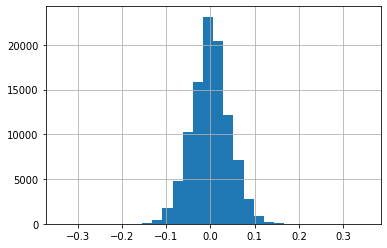

In [ ]:
Y.hist(bins=30)

In [ ]:
X.shape, Y.shape

((100000, 287), (100000,))

#To evaluate fit level i will be using Loss function. R^2. The main goal of this task is to find a model wihich will be maximize R2.

In [ ]:
def metric(Y, Y_pred):
    return metrics.r2_score(Y, Y_pred)

In [ ]:
# below import of necessary libraries which I will use in this project
from sklearn.metrics import r2_score

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import time


In [ ]:
linear_regression = LinearRegression()
# scoring function for linear reggression
def r2_est(X,y):
    return r2_score(y, linear_regression.fit(X,y).predict(X))

### decided to try PCA at first without dimension reduction, I just want to see how many dimensions it takes to achieve 95% variance. The answer is 5 :).


In [ ]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
# d=5

5

### below is a plot which nicely describing how variance level depends from dimmensions number.

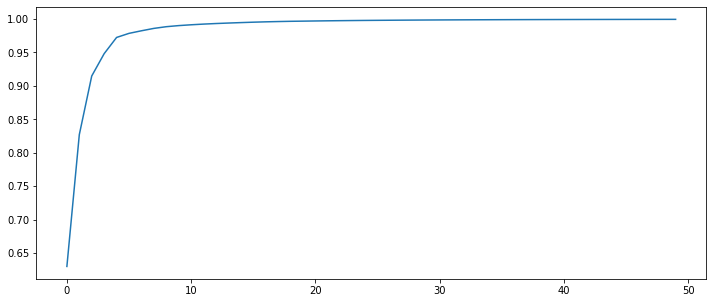

In [ ]:
f = plt.figure(figsize=(12, 5))
plt.plot(cumsum[:50]);

### I created a simple function which I hope will tell me what is the optimal number of functions that I should use in the analysis

In [ ]:

def feature_r2_curve(X,Y, n_f):
    tic = time.perf_counter()
    
    ffs_r = []
    pca_r =[]
    sfs_r = []
    skb_r = []

    for i in range(1, n_f):
        # feautre selection based on best fited featueres to lr model
        features_selection = SelectFromModel(LinearRegression(), max_features=i)
        features_selection.fit(X, Y)
        features = list(X.columns[features_selection.get_support()])
        X_ffs = X[features]
        
        # based on previos PCA analysis i know that i need only 5 dimmension if i want go deeper       
        pca = PCA(n_components=i)
        pca.fit(X)
        pca_data = pca.transform(X)
        pca_labels = ['pc_' + str(x) for x in range(1, i + 1)]
        X_pca = pd.DataFrame(data = pca_data, columns=pca_labels)
        
        #here is use forward feature selection         
        sfs = SFS(LinearRegression(), k_features=i, forward=True, floating=False, scoring = 'r2',cv = 0)
        sfs.fit(X, Y)
        features_lst = list(sfs.k_feature_names_)
        X_sfs = X[features_lst]
        
        skb = SelectKBest(score_func=f_regression, k=i)
        skb.fit(X, Y)
        skb_f = list(X.columns[skb.get_support()])
        X_skb = X[skb_f]
        
        r2_ffs = r2_est(X_ffs, Y)
        r2_pca = r2_est(X_pca, Y)
        r2_sfs = r2_est(X_sfs, Y)
        r2_skb = r2_est(X_skb, Y)
        
        ffs_r.append(r2_ffs)
        pca_r.append(r2_pca)
        sfs_r.append(r2_sfs)
        skb_r.append(r2_skb)
        
    toc = time.perf_counter()
    print(f'operational time: {toc - tic:0.2f} seconds')
    # function will return tabels for each method with r2 values
    return [ffs_r, pca_r, sfs_r, skb_r]

### this function is similar like one before, but with this difference that this time i want only extract features which i will use in next step

In [ ]:
def feature_selection(X,Y, n_f=5):
    
    features_selection = SelectFromModel(LinearRegression(), max_features=n_f)
    features_selection.fit(X, Y)
    features = list(X.columns[features_selection.get_support()])
    X_ffs = X[features]
        
    pca = PCA(n_components=n_f)
    pca.fit(X)
    pca_data = pca.transform(X)
    pca_labels = ['pc_' + str(x) for x in range(1, n_f + 1)]
    X_pca = pd.DataFrame(data = pca_data, columns=pca_labels)
        
    sfs = SFS(LinearRegression(), k_features=n_f, forward=True, floating=False, scoring = 'r2',cv = 0)
    sfs.fit(X, Y)
    features_lst = list(sfs.k_feature_names_)
    X_sfs = X[features_lst]
    
    skb = SelectKBest(score_func=f_regression, k=n_f)
    skb.fit(X, Y)
    skb_f = list(X.columns[skb.get_support()])
    X_skb = X[skb_f]
    
    return X_ffs, X_pca, X_sfs, X_skb


In [ ]:
feature_set = feature_r2_curve(X, Y, 15)

operational time: 1046.29 seconds


### plot below shows that in many cases r2 reaches a value close to the maximum value what is correct with what i saw by using pca method.

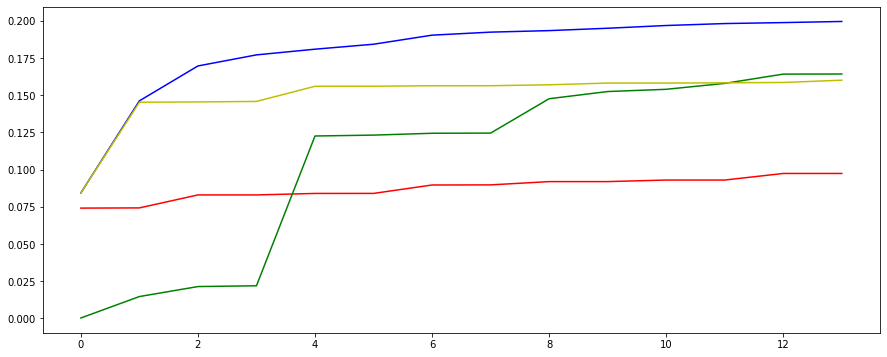

In [ ]:
pca_r = feature_set[0]
ffs_r = feature_set[1]
sfs_r = feature_set[2]
skb_r = feature_set[3]

fig = plt.figure(figsize=(15, 6))
plt.plot(pca_r, c='r')
plt.plot(ffs_r, c='g')
plt.plot(sfs_r, c='b')
plt.plot(skb_r, c='y');

In [ ]:
# compare ml algo to choose the best solutions

def comparing_models(features_min, features_max):
    # features preparation
    for i in range(features_min, features_max+1):
        print('number of features:', i)
        feature_sel = feature_selection(X, Y, i)
        X_ffs, X_pca, X_sfs, X_skb = feature_sel

        features_selected = []
        features_selected.append(('FFS', X_ffs))
        features_selected.append(('SFS', X_sfs))
        features_selected.append(('SKB', X_skb))

        # models preparation
        models = []
        models.append(( 'LR' , LinearRegression()))
        models.append(( 'RDG' , Ridge()))
        models.append(( 'SGD' , SGDRegressor()))
        
        # valuation of each model for each iteration
        results = []
        names = []
        fnames = []
        scoring = 'r2'
        for fname, features in features_selected:
            print(fname)
            for name, model in models:
                # generally i picked the approach of testing different selection methods
                # and at a later stage of training and testing the model, I will use the CV method
                # due to the possibility of quickly dividing the data set into small processes, it seems to me that
                # this method should produce a good fit model when used on new data with a similar distribution
                kfold = KFold(n_splits=10) #  random_state=7, shuffle=True
                cv_results = cross_val_score(model, features, Y, cv=kfold, scoring=scoring)
                results.append(cv_results)
                fnames.append(fname)
                names.append(name)
                msg = f'{name}: {cv_results.mean()} {(cv_results.std())}'
                print(msg)
        # comparative visualization
        fig = plt.figure(figsize=(12,6))
        fig.suptitle( 'Algorithm Comparison' )
        ax = fig.add_subplot(111)
        plt.boxplot(results)
        ax.set_xticklabels(names)
        plt.show()

### the following visualization shows that the forward feature selection method seems to be at its best degree maximize the value of r2 linear regression models and linear modified regression (ridge), but because of the possibility seeking selection model selection Ridge ()



number of features: 2
FFS
LR: 0.07362766136766599 0.008082406783313088
RDG: 0.07353754140689157 0.007866341012238803
SGD: 0.07058845199016645 0.005879185574688601
SFS
LR: 0.14650467754412183 0.021413523124412793
RDG: 0.14629181507661326 0.02058733519480855
SGD: 0.021046453690730625 0.001625313927911821
SKB
LR: 0.14554178277102842 0.020832666824672455
RDG: 0.1453890402197136 0.020157024476524083
SGD: 0.025528540769267284 0.0019416236110662277


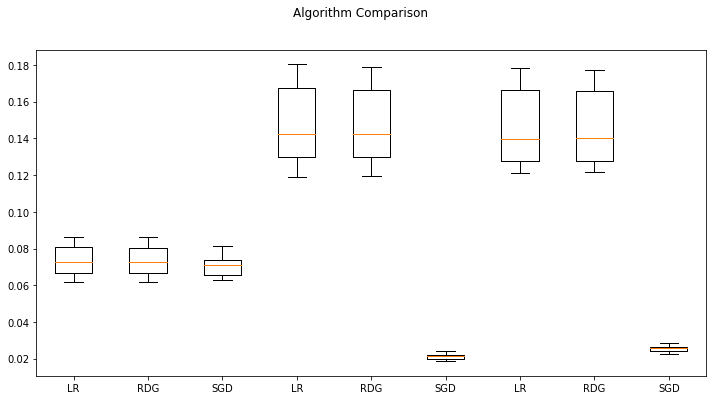

number of features: 3
FFS
LR: 0.08242198339767805 0.009962369950744596
RDG: 0.07787573774638396 0.008286191843859326
SGD: 0.07323210181596249 0.006972403309729867
SFS
LR: 0.17018020283830562 0.020283618292304077
RDG: 0.16997736588856835 0.019662312381352253
SGD: 0.0434710976936877 0.004890280160625517
SKB
LR: 0.14574151534116334 0.0207269204559625
RDG: 0.14468449526077123 0.020375392686633863
SGD: 0.04874798029960349 0.0030619099294743753


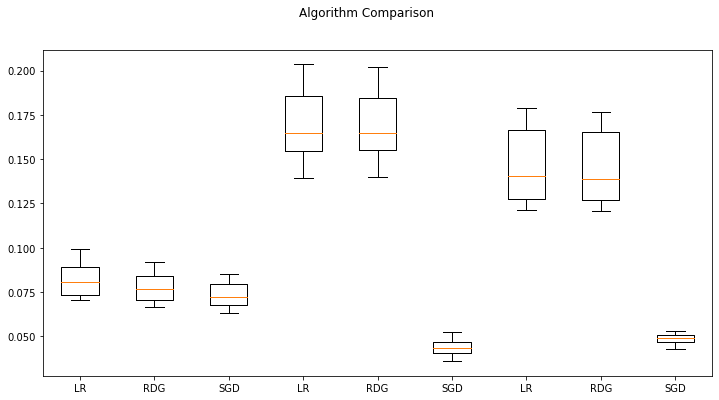

number of features: 4
FFS
LR: 0.08235264047537294 0.010023980749633716
RDG: 0.07896986756425063 0.00844124367186761
SGD: 0.07430686477891016 0.0076052773219250115
SFS
LR: 0.17743225954680958 0.018857233536855162
RDG: 0.17714053461137325 0.018503067202980315
SGD: 0.048030825479714837 0.00493036365854702
SKB
LR: 0.14602648515742664 0.021088131035829745
RDG: 0.14506808985042471 0.02094345871499827
SGD: 0.05930516679730132 0.004403293959984954


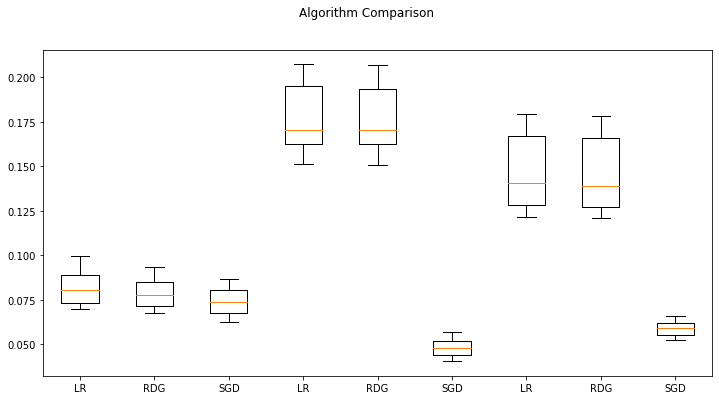

number of features: 5
FFS
LR: 0.08336424982956393 0.010398530300174296
RDG: 0.07929650038585746 0.00853447827375685
SGD: 0.07430521130610082 0.00803367962322453
SFS
LR: 0.17412527895474 0.02717213936147949
RDG: 0.17417433280402755 0.026331126323113394
SGD: 0.05418942754335544 0.006151748326786561
SKB
LR: 0.1562624508742818 0.022528672118752226
RDG: 0.15474816513167297 0.021860982294376923
SGD: 0.09669386436113483 0.008048402482571873


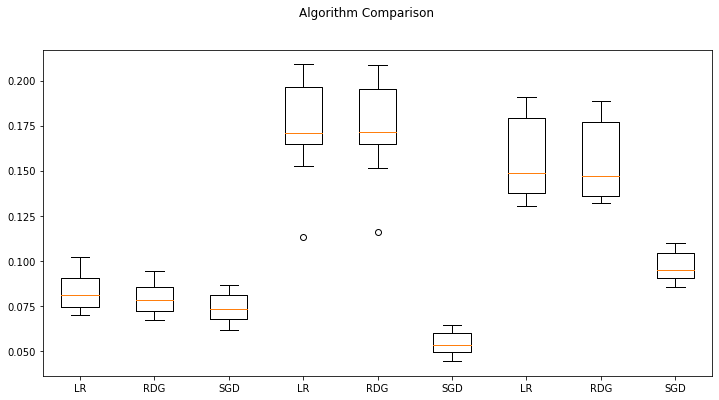

number of features: 6
FFS
LR: 0.08304243092304217 0.010668522612466579
RDG: 0.07931839120375772 0.008548808548798546
SGD: 0.0740295852787817 0.00764507586834948
SFS
LR: 0.17969913246803498 0.02147275838373026
RDG: 0.17891499051299775 0.021890085416222282
SGD: 0.06378916051093604 0.006596332447775915
SKB
LR: 0.15618709884879106 0.02260614383066528
RDG: 0.15474823158736825 0.021863497551308658
SGD: 0.10332483719826593 0.00901084390900536


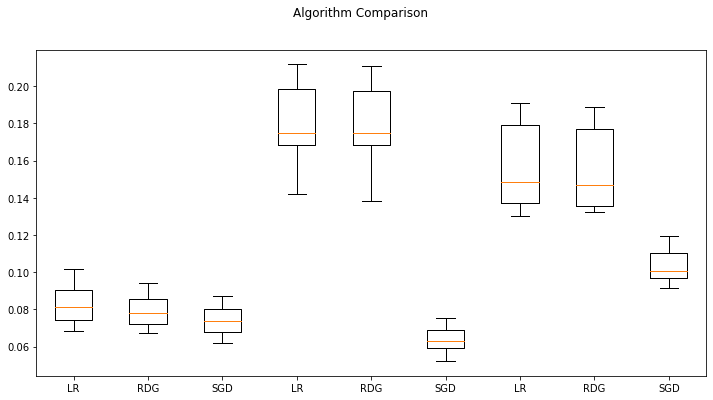

number of features: 7
FFS
LR: 0.08855866885744638 0.01148016092188008
RDG: 0.0816342063655211 0.008985626759248234
SGD: 0.07468186084942627 0.008306469187549886
SFS
LR: 0.1867737781125967 0.020190889102031494
RDG: 0.18577994188657534 0.021314207866714806
SGD: 0.10928980389210072 0.00896011723963567
SKB
LR: 0.1564721532335297 0.02245871092087203
RDG: 0.15492455938955874 0.021782710002884478
SGD: 0.10383971047470904 0.009746974928087829


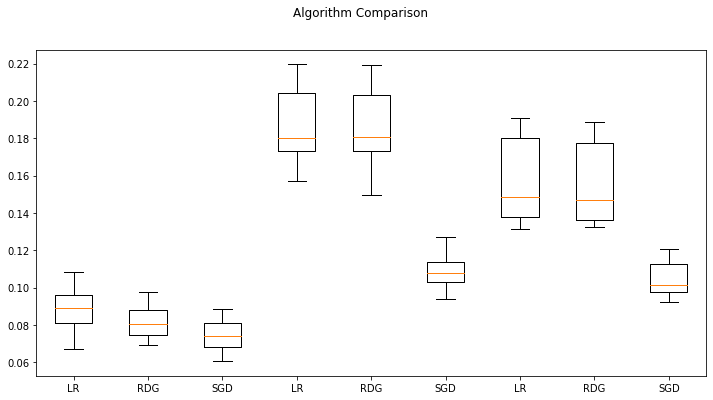

number of features: 8
FFS
LR: 0.08836659179327913 0.011536154041690855
RDG: 0.08234027248153718 0.009158025386836867
SGD: 0.07493675644729962 0.007674745129338708
SFS
LR: 0.1875755179405551 0.021776605455388787
RDG: 0.18801747310994218 0.020113631305367148
SGD: 0.11552122246265398 0.00949695515985461
SKB
LR: 0.15635809872291756 0.02251667140949583
RDG: 0.1549298372401461 0.02176967942314043
SGD: 0.10345486707819304 0.010174277543225366


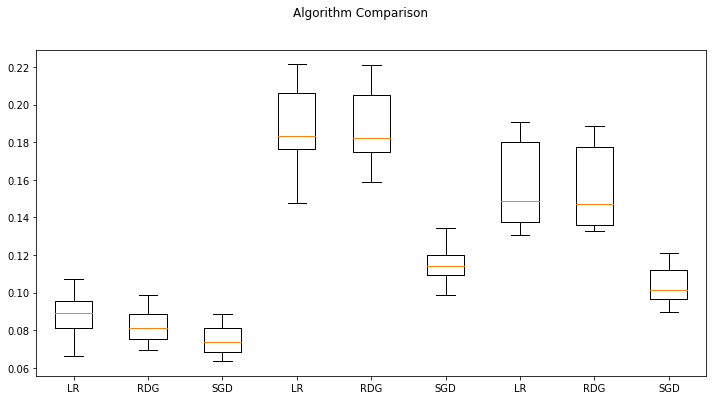

number of features: 9
FFS
LR: 0.09046542327026594 0.01054264801427228
RDG: 0.08378254234613888 0.008488671278787361
SGD: 0.07514999358432371 0.007949180235677403
SFS
LR: 0.18430817348907877 0.03172740038215543
RDG: 0.1852141292729991 0.028312638374312565
SGD: 0.11735665921558294 0.010108147843795203
SKB
LR: 0.1569530173992773 0.02240585497404535
RDG: 0.15486343460614466 0.021753258398095575
SGD: 0.10395613625192195 0.009695018129673863


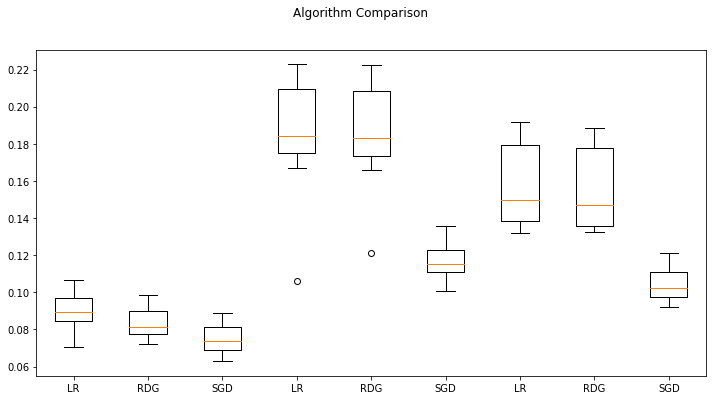

number of features: 10
FFS
LR: 0.09046734126482264 0.010540976771247322
RDG: 0.08384171228955532 0.00841528441648468
SGD: 0.07547104642115866 0.008379169833305491
SFS
LR: 0.18428243156759502 0.036042885561674315
RDG: 0.1857575293611191 0.03072009650452046
SGD: 0.11727468563030011 0.010452840398845274
SKB
LR: 0.15807755103825963 0.021964652152825417
RDG: 0.15550454897033342 0.02161444083926884
SGD: 0.10371849374513867 0.010396105596480288


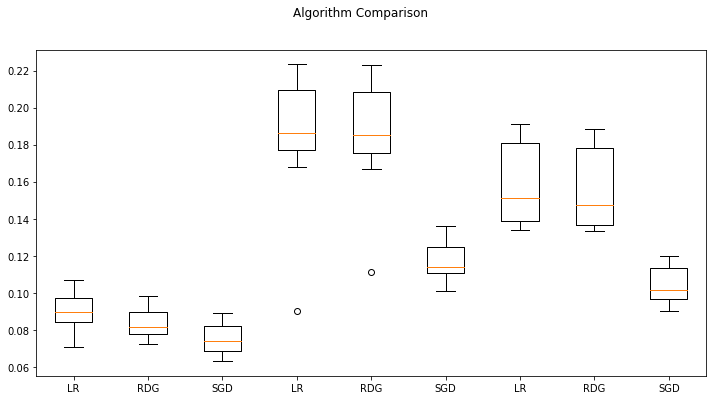

number of features: 11
FFS
LR: 0.0914958596297353 0.011243980540589258
RDG: 0.08487670535771281 0.0088948106442309
SGD: 0.07524525976784217 0.008396174949487486
SFS
LR: 0.1955112921307678 0.018220876038534443
RDG: 0.19527550353323528 0.018442908628868437
SGD: 0.09375751125191033 0.06931523308717612
SKB
LR: 0.15803012156559634 0.021958587702195772
RDG: 0.1556847694354526 0.021571474617524667
SGD: 0.10309866705163592 0.010602922413624304


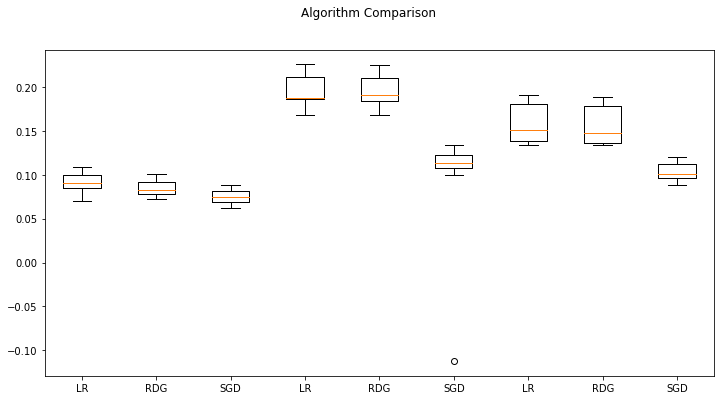

number of features: 12
FFS
LR: 0.09142576163590158 0.011273337772769685
RDG: 0.08487793397484289 0.008903361759876558
SGD: 0.07541193816845534 0.008496991182734346
SFS
LR: 0.1963820912887381 0.019102134579897123
RDG: 0.19686543650192306 0.01898004435454058
SGD: 0.09142248842499151 0.07191884143907411
SKB
LR: 0.15817262003480254 0.022139638992722806
RDG: 0.15565464876216123 0.02151733472319456
SGD: 0.10481446762344712 0.010580423981512226


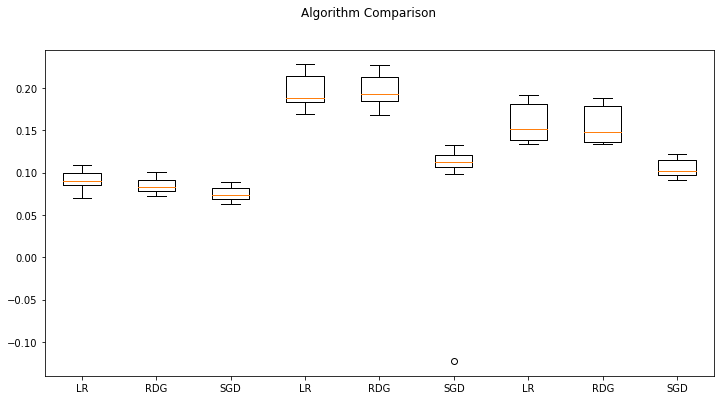

number of features: 13
FFS
LR: 0.09590792864693473 0.010857522200902955
RDG: 0.08688598219730179 0.008957618071992935
SGD: 0.07493908101437856 0.007578722497179464
SFS
LR: 0.19684888729610428 0.018950485456603675
RDG: 0.19720400315490733 0.01890266323101668
SGD: 0.09730798389276872 0.0806823067791202
SKB
LR: 0.1583311541800853 0.022243257383680718
RDG: 0.1556371299850961 0.02153617154108243
SGD: 0.10468821433942477 0.010335371555723205


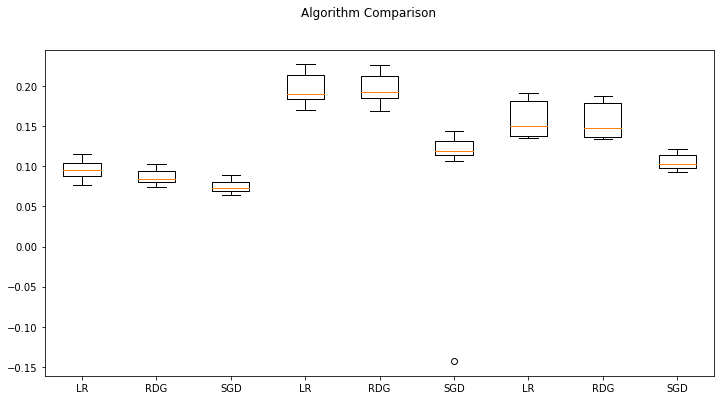

number of features: 14
FFS
LR: 0.09566859662884694 0.011102450457526194
RDG: 0.08752898500093692 0.00899204612763741
SGD: 0.07478722401770041 0.0072876887306895805
SFS
LR: 0.19739850755183339 0.019457139062624078
RDG: 0.19784125129095906 0.018981598836684068
SGD: 0.10198196204589935 0.07503651228097553
SKB
LR: 0.15969343133186759 0.022275639193691688
RDG: 0.15567953020136127 0.02152863432081148
SGD: 0.10394968375903366 0.00990131102364325


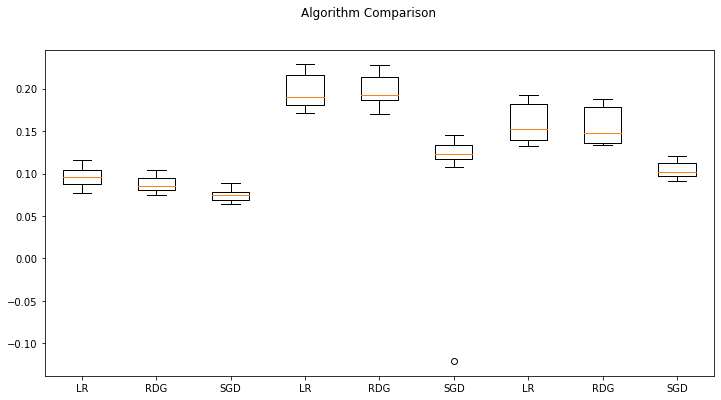

number of features: 15
FFS
LR: 0.09563595341001113 0.011108222987643879
RDG: 0.08772965596935198 0.008979070575714706
SGD: 0.07527713287342071 0.007769038658384831
SFS
LR: 0.19651916142696707 0.026648817492389964
RDG: 0.20086720991322315 0.01860221458788473
SGD: 0.103810635745507 0.07185501633501651
SKB
LR: 0.15948516799981913 0.02237570398342206
RDG: 0.1556956486985293 0.021527506267239094
SGD: 0.10414597010369024 0.01028973951513485


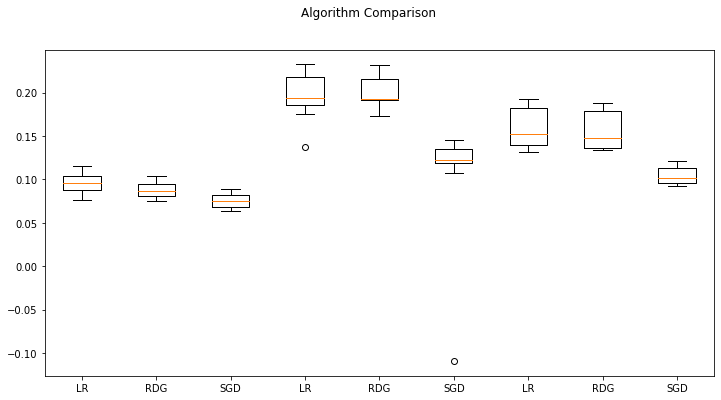

In [ ]:
comparing_models(2, 15)


In [ ]:
# this workflow will help me to fit my model by finding right parameteres to it.
# test for 5 dimmension
X_sfs = feature_selection(X, Y, 5)[2]
alphas = np.array([1,0.1,0.01,0.001,0.0001,0.00001, 0])
param_grid = dict(alpha=alphas)
scoring = 'r2'
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring)
grid.fit(X_sfs, Y)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.1734420787803666
0.1


In [ ]:
# test for 7 dimmension
X_sfs = feature_selection(X, Y, 7)[2]
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
param_grid = dict(alpha=alphas)
scoring = 'r2'
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring)
grid.fit(X_sfs, Y)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.18629827181926165
0.0


# Model: A the end, i decided to use Ridge model, becouse i can fit model by using regularization.
# Feature selection method: SFS, i decided to use only 5 dimmension, the main reason is that with this number of features i still can keep quite high level of r2 with alpha which is in that case 0.1
## Selected featueres like below: 

In [ ]:
X_sfs.columns

Index(['f44', 'f95', 'f276', 'f280', 'f291'], dtype='object')

# Final workflow

In [ ]:
sfs = SFS(LinearRegression(), k_features=5, forward=True, floating=False, scoring = 'r2',cv = 0)
sfs.fit(X, Y)
features_lst = list(sfs.k_feature_names_)
X_sfs = X[features_lst]
model = Ridge(alpha=0.1)
model.fit(X_sfs, Y)
y_hat = model.predict(X_sfs)

# Final result:

In [ ]:
metric(Y, y_hat)

0.18098214563213144

# Snippet below should allow me to test my model on new data with similar distribution

In [ ]:
X_sfs = X[features_lst]
yh = model.predict(X_sfs)
metric(Y, yh)

0.18098214563213144